# Sample Diagnostic

Example of a diagnostic showing how the COSIMA cookbook works.

An objective of the COSIMA cookbook is to catalogue useful diagnostics for ocean and ice models.  Certain
tools and patterns are used extensively in these examples.  While the diagnostic itself should be portable
to another framework, there are some conventions used throughout that require explanation.

## Background of a diagnostic notebook

Each diagnostic is written up as a Jupyter notebook with the extension `.ipynb`.  The first cell in the notebook
must be a Markdown cell with a header and a one-line description.  This cell is used by sphinx-nbgallery to collect
all of the diagnostics together the http://cosima-cookbook.readthedocs.io site. 

In this first section, a brief background on the theory of the diagnostic is presented. For this worked example, we will be calculating the eddy kinetic energy (see the Kinetic Energy notebook).  While in real diagnostic notebook, commentary about the diagnostic is presented, here we provide commentary about the technical aspects of how these diagnostics have been implemented.

### A note on names
- The project's long name is "COSIMA Cookbook".
- The GitHub project name is "cosima-cookbook".
- The Python package is called "cosima_cookbook". 

This conventions appears to be consistent with other Python based projects.

### Python import statements

Early in the notebook, there is a code cell that imports all of the needed Python packages.  Internal to cosima_cookbook, other packages may also be important. But, if they are needed in this notebook, they must be
imported explicitly into the namespace.

#### Example of a import cell block

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from tqdm import tqdm_notebook

For static plots, the plotting package matplotlib is used. The inline statement tells Jupyter to place those plots within the notebook file.

It is common to import standard packages with abbreviated package names such as plt, np, pd, and xr. XArray is for
named arrays and can be thought of as layer that sits above the netCDF4 package.

The package tqdm is for progress bars.

These diagnostics are usually very memory and/or computationally expensive.  We leverage the `dask` library http://dask.pydata.org and its related package `distributed` https://distributed.readthedocs.io.

In [3]:
import dask
import distributed

By default, we create a collection of workers -- one work for each core. The memory is set as 70% of the total memory of the node. Beyond that, distributed will start caching results locally.

In [4]:
client = distributed.Client()
client

Client Scheduler: tcp://127.0.0.1:37206 Dashboard: http://127.0.0.1:8787,Cluster Workers: 8 Cores: 8 Memory: 20.20 GB


You see above that there is a URL for the Dashboard. This is a very useful tool for inspecting the progress of a dask
calculation. If you are running the VDI over VNC you should be able to click on the link to make the dashboard open in another tab.  

If you are running this notebook over a SSH tunnel, you will also have to tunnel the port for the dashboard to your local machine. Here's some code which generates the need string.  Run that command on your local machine. Then the link above should work.  

In [5]:
import os

params = {'host': os.environ['HOSTNAME'],
          'user': os.environ['USER'],
          'port': client.scheduler_info()['services']['bokeh']}

tunnel_cmd = "ssh {host}.nci.org.au -l {user} -L {port}:127.0.0.1:{port}".format(**params)
print(tunnel_cmd)

ssh vdi-n11.nci.org.au -l jm0634 -L 8787:127.0.0.1:8787


### Organization of the model data

By default, all of the model output is assumed to stored in the directory given by

In [11]:
import cosima_cookbook.netcdf_index
cosima_cookbook.netcdf_index.directoriesToSearch

['/g/data3/hh5/tmp/cosima/', '/g/data1/v45/APE-MOM']

This global variable may be changed if needed.



In [13]:
datadir = cosima_cookbook.netcdf_index.directoriesToSearch[0]

In [14]:
!ls {datadir}

access-om2  access-om2-025  bathymetry	mom01v5  mom025  mom-sis  README  woa13


The data directory contains several model __configurations__ (mom01v5 or mom025)

In [15]:
!ls {datadir}/mom01v5

climatology  KDS75	       KDS75_saltfluxes  KDS75_WOA13
figures      KDS75_PI	       KDS75_UP		 MOM01_Diagnostics.ipynb
GFDL50	     KDS75_salt10days  KDS75_wind


Each configuration contains a number of __experiments__ (KDS75 or KDS75_wind)

In [16]:
!ls {datadir}/mom01v5/KDS75_salt10days

output266  output273  output280  output287  output294  output301   restart300
output267  output274  output281  output288  output295  output302   restart306
output268  output275  output282  output289  output296  output303
output269  output276  output283  output290  output297  output304
output270  output277  output284  output291  output298  output305
output271  output278  output285  output292  output299  output306
output272  output279  output286  output293  output300  restart280


Which are each made up of a set of several __runs__ (e.g. output266)

In [17]:
!ls {datadir}/mom01v5/KDS75_salt10days/output266

config.yaml  field_table   logfile.000000.out  ocean_grid.nc   ocean_scalar.nc
data_table   ice_month.nc  mom.err	       ocean_month.nc  overturning.nc
diag_table   input.nml	   mom.out	       ocean.nc        time_stamp.out


The actual model out in stored in NetCDF4 files (denoted by the extention .nc). 

In [18]:
fn = os.path.join(datadir, 'mom01v5/KDS75_salt10days/output266/ocean.nc')
xr.open_dataset(fn)

/g/data1/v45/jm0634/miniconda3/envs/cosima/lib/python3.6/site-packages/xarray/conventions.py:393: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/g/data1/v45/jm0634/miniconda3/envs/cosima/lib/python3.6/site-packages/xarray/conventions.py:412: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


<xarray.Dataset>
Dimensions:         (grid_xt_ocean: 3600, grid_yu_ocean: 2700, nv: 2, potrho: 80, potrho_edges: 81, st_edges_ocean: 76, st_ocean: 75, sw_edges_ocean: 76, sw_ocean: 75, time: 1, xt_ocean: 3600, xu_ocean: 3600, yt_ocean: 2700, yu_ocean: 2700)
Coordinates:
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 ...
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 -80.98 -80.94 ...
  * time            (time) object   70-02-15 00:00:00
  * nv              (nv) float64 1.0 2.0
  * xu_ocean        (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 ...
  * yu_ocean        (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 ...
  * st_ocean        (st_ocean) float64 0.5413 1.681 2.94 4.332 5.869 7.569 ...
  * st_edges_ocean  (st_edges_ocean) float64 0.0 1.083 2.279 3.601 5.062 ...
  * grid_xt_ocean   (grid_xt_ocean) float64 -279.9 -279.8 -279.7 -279.6 ...
  * grid_yu_ocean   (grid_yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ...
  * potrho      

There are many, many such NetCDF4 files.

In [ ]:
!find {datadir} -name '*.nc' | wc

__Runs__ may change which variables they saved and at what temporal resolution over the course of an __experiment__.  Rather than trying to enumerate the variables _a priori_, we can a data discovery approach using a glob.

In [4]:
directoriesToSearch = ['/g/data3/hh5/tmp/cosima/', 
                      ]

In [5]:
import netCDF4

In [6]:
import dataset
import re
import os
import fnmatch

Build index of all NetCDF files found in directories to search. 

In [47]:
%%time
m = re.compile('.*\.nc$')

ncfiles = []
for directoryToSearch in directoriesToSearch:
    for root, dirs, filenames in os.walk(directoryToSearch):
        for filename in filenames:
            if m.match(filename) is not None:
                ncfiles.append(os.path.join(root, filename))

print(len(ncfiles))

17598
CPU times: user 1.69 s, sys: 1.38 s, total: 3.07 s
Wall time: 18.2 s


We can persist this index by storing it in a sqlite database placed in a centrally available location.

In [48]:
cosima_cookbook_dir = '/g/data1/v45/cosima-cookbook'
if not os.path.exists(cosima_cookbook_dir):
    os.mkdir(cosima_cookbook_dir)

database_file = '/{}/cosima-cookbook.db'.format(cosima_cookbook_dir)

In [38]:
# os.remove(database_file)

FileNotFoundError: [Errno 2] No such file or directory: '//g/data1/v45/cosima-cookbook/cosima-cookbook.db'

The use of the `dataset` module hides the details of working with SQL directly.

In [49]:
db = dataset.connect('sqlite://' + database_file)

In this database is a single table listing all variables in NetCDF4 seen previously.

In [50]:
files_already_seen = set([_['ncfile'] for _ in db['ncfiles'].distinct('ncfile')])
print(len(files_already_seen))

17129


NetCDF files found on disk not seen before:

In [51]:
files_to_add = set(ncfiles) - set(files_already_seen)
print(len(files_to_add))

469


For these new files, we can determine their configuration, experiment, and run. Using NetCDF4 to get list of all variables in each file.

In [52]:
# output* directories
# match the parent and grandparent directory to configuration/experiment
m = re.compile('(.*)/(.*)/(.*)/(output\d+)/.*\.nc')

def index_variables(ncfile):

    matched = m.match(ncfile)
    if matched is None:
        return []
    
    if not os.path.exists(ncfile):
        return []
    
    try: 
        with netCDF4.Dataset(ncfile) as ds:
            ncvars = [ {'ncfile': ncfile,
                   'rootdir': matched.group(1),
                   'configuration': matched.group(2),
                   'experiment' : matched.group(3),
                   'run' : matched.group(4),
                   'basename' : os.path.basename(ncfile),
                   'variable' : v.name
                   } for v in ds.variables.values()]
    except:
        return []
    
    return ncvars

Parallel approach

In [53]:
import dask.bag
from distributed.diagnostics.progressbar import progress

In [54]:
%%time

bag = dask.bag.from_sequence(files_to_add)
bag = bag.map(index_variables).flatten()
ncvars = bag.compute()

CPU times: user 479 ms, sys: 39 ms, total: 518 ms
Wall time: 516 ms


In [55]:
print(len(ncvars))

0


In [56]:
db['ncfiles'].insert_many(ncvars)

In [18]:
import pandas as pd

In [19]:
files = pd.DataFrame(list(db['ncfiles'].all()))

In [20]:
files

,id,ncfile,rootdir,configuration,experiment,run,basename,variable
0,1,/g/data3/hh5/tmp/cosima/mom01v5/KDS75_UP/outpu...,/g/data3/hh5/tmp/cosima,mom01v5,KDS75_UP,output336,overturning.nc,xt_ocean
1,2,/g/data3/hh5/tmp/cosima/mom01v5/KDS75_UP/outpu...,/g/data3/hh5/tmp/cosima,mom01v5,KDS75_UP,output336,overturning.nc,yt_ocean
2,3,/g/data3/hh5/tmp/cosima/mom01v5/KDS75_UP/outpu...,/g/data3/hh5/tmp/cosima,mom01v5,KDS75_UP,output336,overturning.nc,time
3,4,/g/data3/hh5/tmp/cosima/mom01v5/KDS75_UP/outpu...,/g/data3/hh5/tmp/cosima,mom01v5,KDS75_UP,output336,overturning.nc,nv
4,5,/g/data3/hh5/tmp/cosima/mom01v5/KDS75_UP/outpu...,/g/data3/hh5/tmp/cosima,mom01v5,KDS75_UP,output336,overturning.nc,xu_ocean
5,6,/g/data3/hh5/tmp/cosima/mom01v5/KDS75_UP/outpu...,/g/data3/hh5/tmp/cosima,mom01v5,KDS75_UP,output336,overturning.nc,yu_ocean
6,7,/g/data3/hh5/tmp/cosima/mom01v5/KDS75_UP/outpu...,/g/data3/hh5/tmp/cosima,mom01v5,KDS75_UP,output336,overturning.nc,st_ocean
7,8,/g/data3/hh5/tmp/cosima/mom01v5/KDS75_UP/outpu...,/g/data3/hh5/tmp/cosima,mom01v5,KDS75_UP,output336,overturning.nc,st_edges_ocean
8,9,/g/data3/hh5/tmp/cosima/mom01v5/KDS75_UP/outpu...,/g/data3/hh5/tmp/cosima,mom01v5,KDS75_UP,output336,overturning.nc,grid_xt_ocean
9,10,/g/data3/hh5/tmp/cosima/mom01v5/KDS75_UP/outpu...,/g/data3/hh5/tmp/cosima,mom01v5,KDS75_UP,output336,overturning.nc,grid_yu_ocean


Files seen before but now not found on disk

Notice that, unlike the find command above, the glob has only identified .nc files that with in the
__configuration__/__experiment__/__run__ directory structure.

We want to produce an index over all of these NetCDF files. Once we do that, we can build our diagnostics by first
querying that index.

In [15]:
rows = [cosima_cookbook.index_ncfile(fn[0]) for fn in ncfiles[:15]]

index_ncfile() returns a list of dictionaries describing each variable in an the NetCDF file. 

In [16]:
rows[0][:3]

[{'chunking': (1440,),
  'configuration': '',
  'dimensions': ('xt_ocean',),
  'experiment': 'mom025/mom025_jra_ryf9091_saltunderice',
  'name': 'xt_ocean',
  'ncfile': 'ocean.nc',
  'ncpath': '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091_saltunderice/output076/ocean.nc',
  'run': ''},
 {'chunking': (1080,),
  'configuration': '',
  'dimensions': ('yt_ocean',),
  'experiment': 'mom025/mom025_jra_ryf9091_saltunderice',
  'name': 'yt_ocean',
  'ncfile': 'ocean.nc',
  'ncpath': '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091_saltunderice/output076/ocean.nc',
  'run': ''},
 {'chunking': (50,),
  'configuration': '',
  'dimensions': ('st_ocean',),
  'experiment': 'mom025/mom025_jra_ryf9091_saltunderice',
  'name': 'st_ocean',
  'ncfile': 'ocean.nc',
  'ncpath': '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091_saltunderice/output076/ocean.nc',
  'run': ''}]

The list comprehension gives back a list of lists.  To continue, we first flatten this list of lists:

In [17]:
rows = [item for sublist in rows for item in sublist]

Finally, we can convert this dictionary 

In [18]:
df = pd.DataFrame(rows)

In [19]:
df

,chunking,configuration,dimensions,experiment,name,ncfile,ncpath,run
0,"(1440,)",,"(xt_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,xt_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
1,"(1080,)",,"(yt_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,yt_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
2,"(50,)",,"(st_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,st_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
3,"(51,)",,"(st_edges_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,st_edges_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
4,"(1,)",,"(time,)",mom025/mom025_jra_ryf9091_saltunderice,time,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
5,"(2,)",,"(nv,)",mom025/mom025_jra_ryf9091_saltunderice,nv,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
6,"(1440,)",,"(xu_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,xu_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
7,"(1080,)",,"(yu_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,yu_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
8,"(50,)",,"(sw_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,sw_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
9,"(51,)",,"(sw_edges_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,sw_edges_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,


So this gives us a nice index for all variables over all NetCDF files.  However, since we have tens of thousands of ncfiles, generating this index can be slow.  To improve performance, we can use a dask bag.

In [34]:
bag = dask.bag.from_sequence([_[0] for _ in ncfiles],npartitions=1000)
rows = bag.map(cosima_cookbook.index_ncfile)

In [35]:
futures = client.compute(rows)

In [38]:
futures

<Future: status: error, key: finalize-75b876d2ab32a25d28759ff2ab75ab04>

In [52]:
import dataset

In [46]:
progress(futures)

To actually get the computation to occur, we can conver the bag into a list.  This takes a few minutes.

As before, we convert the list of lists to a single list

In [21]:
rows = [item for sublist in rows for item in sublist]

Finally, we can put this all into a pandas DataFrame

In [22]:
df = pd.DataFrame.from_records(rows)

In [23]:
df

,chunking,configuration,dimensions,experiment,name,ncfile,ncpath,run
0,"(1440,)",,"(xt_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,xt_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
1,"(1080,)",,"(yt_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,yt_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
2,"(50,)",,"(st_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,st_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
3,"(51,)",,"(st_edges_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,st_edges_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
4,"(1,)",,"(time,)",mom025/mom025_jra_ryf9091_saltunderice,time,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
5,"(2,)",,"(nv,)",mom025/mom025_jra_ryf9091_saltunderice,nv,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
6,"(1440,)",,"(xu_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,xu_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
7,"(1080,)",,"(yu_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,yu_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
8,"(50,)",,"(sw_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,sw_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
9,"(51,)",,"(sw_edges_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,sw_edges_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,


The above steps are implemented in

In [28]:
df = cosima_cookbook.build_index()

Here are all of the unique experiments found in the data

In [40]:
expts = df.experiment.unique()
expts

array(['mom01v5/GFDL50', 'mom01v5/KDS75', 'mom01v5/KDS75_PI',
       'mom01v5/KDS75_UP', 'mom01v5/KDS75_salt10days',
       'mom01v5/KDS75_saltfluxes', 'mom01v5/KDS75_wind',
       'mom025/mom025_jra_ryf0304', 'mom025/mom025_jra_ryf8485',
       'mom025/mom025_jra_ryf9091',
       'mom025/mom025_jra_ryf9091_saltunderice', 'mom025/mom025_nyf',
       'mom025/mom025_nyf_salt'], dtype=object)

In [43]:
expts[7]

'mom025/mom025_jra_ryf0304'

In [49]:
list(df)

['chunking',
 'configuration',
 'dimensions',
 'experiment',
 'name',
 'ncfile',
 'ncpath',
 'run']

## Calculation of EKE

Let's choose a specific experiment:

In [57]:
pd.DataFrame(list(db['ncfiles'].distinct('configuration', 'experiment')))

,configuration,experiment
0,access-om2-025,025deg_jra55_ryf
1,access-om2-025,025deg_jra55_ryf_spinup1
2,mom01v5,GFDL50
3,mom01v5,KDS75
4,mom01v5,KDS75_PI
5,mom01v5,KDS75_UP
6,mom01v5,KDS75_salt10days
7,mom01v5,KDS75_saltfluxes
8,mom01v5,KDS75_wind
9,mom025,mom025_jra_ryf0304


In [63]:
db['ncfiles'].columns

['id',
 'ncfile',
 'rootdir',
 'configuration',
 'experiment',
 'run',
 'basename',
 'variable']

In [58]:
expt = 'KDS75'
expt

'KDS75'

To calculate the eddy kinetic energy, we are going to consider only  portions of simulations which have 5-day average velocities saved, which means directories with `ocean__*.nc` files.

In [81]:
res = db.query('SELECT ncfile FROM ncfiles \
                WHERE experiment = "KDS75" \
                AND basename LIKE "%ocean__%" \
                AND variable = "u" \
                ORDER BY ncfile \
               ')
ncfiles = [row['ncfile'] for row in res]
ncfiles

['/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output047/ocean.nc',
 '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output048/ocean.nc',
 '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output049/ocean.nc',
 '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output050/ocean.nc',
 '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output051/ocean.nc',
 '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output052/ocean.nc',
 '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output053/ocean.nc',
 '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output054/ocean.nc',
 '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output055/ocean.nc',
 '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output056/ocean.nc',
 '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output057/ocean.nc',
 '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output058/ocean.nc',
 '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output059/ocean.nc',
 '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output060/ocean.nc',
 '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output061/ocean.nc',
 '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output062/ocean.nc',
 '/g/data3/hh5/tmp/cosim

Using our index of ncfiles, we search for such nc files.

In [55]:
u = cosima_cookbook.get_nc_variable(expt, 'ocean__', 'u', n=6)

OSError: [Errno 24] Too many open files: '/local/v45/jm0634/tmp/joblib/cosima_cookbook/build_index/func_code.py'

In [31]:
@cosima_cookbook.memory.cache
def calc_eke(expt, box_index):
    yi, xi = box_index
   
    box = {'yu_ocean': slice(300*yi, 300*(yi+1)),
           'xu_ocean': slice(400*xi, 400*(xi+1))}
    
    op = lambda p: p.isel(**box)

    u = get_nc_variable(expt, 'ocean__', 'u', op=op, n=72)
    v = get_nc_variable(expt, 'ocean__', 'v', op=op, n=72)
    
    u_avg = u.mean('time')
    v_avg = v.mean('time')

    MKE = 0.5 * (u_avg**2 + v_avg**2)
    MKE = MKE.sum(dim='st_ocean')
    MKE = MKE.to_dataset(name='MKE')
    
    u_ = u - u_avg
    v_ = v - v_avg
    
    EKE = 0.5 * (u_**2 + v_**2)

    EKE = EKE.sum(dim='st_ocean')
    EKE = EKE.to_dataset(name='EKE')

    dsx = xr.merge([MKE, EKE])
    dsx.load()
        
    return dsx

In [32]:
from itertools import product

# ceil(x/y) = (x+y+1)//y
yi = range(2700//(300)) 
xi = range(3600//(400))

box_indexes = list(product(*[yi, xi]))

### Maps

In [ ]:
from mpl_toolkits.basemap import Basemap, shiftgrid

mom01v5/KDS75


/short/v45/jm0634/conda/envs/cosima/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


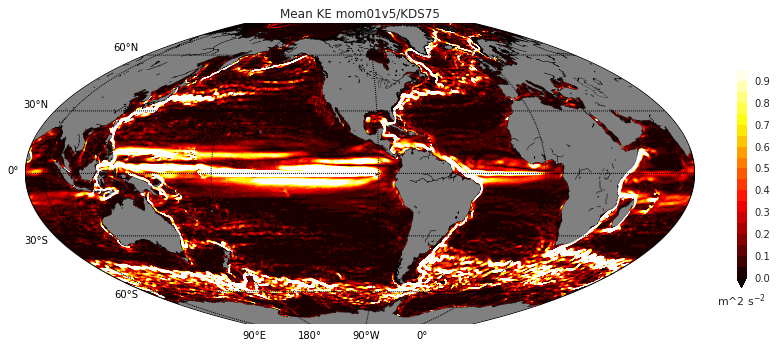

In [15]:
expt = expts[1]

print(expt)
# Plot in basemap 

plt.figure(figsize=(15,6))
lev = np.arange(0, 1.0, 0.05)
map = Basemap(projection='mbtfpq',
              lon_0 = -100, resolution='l')
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
map.drawparallels(np.arange(-60.,61.,30.),
                  labels=[True,False,False,False])
map.drawmeridians(np.arange(-180.,181.,90.),
                  labels=[False,False,False,True])

for box_index in tqdm_notebook(box_indexes):
    #print(box_index)
    dsx = calc_eke(expt, box_index)
    
    x=dsx.xu_ocean[:]
    y=dsx.yu_ocean[:]
    lon, lat = np.meshgrid(x, y)
    
    X, Y = map(lon,lat) 
    
    map.contourf(X, Y, dsx.MKE,
                 cmap=plt.cm.hot,
                 levels=lev,extend='both')

cb = plt.colorbar(orientation='vertical',shrink = 0.7)

cb.ax.set_xlabel('m^2 s$^{-2}$')
plt.title('Mean KE {}'.format(expt))

### Readthedocs website

The diagnostic webpages are generated automatically using Sphinx http://www.sphinx-doc.org and using a Sphinx extention called http://sphinx-nbexamples.readthedocs.io

The readthedocs site is automatically regenerated when every a commit is made to the repository on GitHub.